## Metaflow for Notebook Users

Notebooks have become a critical tool for data scientists — it's super powerful to be able to write code, analyze data, and interleave visualizations, all within a single workspace. However, confidently getting a ML application to production from notebooks as a starting point presents real challenges such as:
- producing reproducible results due to environment dependencies or access to versioned artifacts like data and models
- difficulties switching easily between experimentation and deployment
- tracking and comparing different runs of your models 

#### Perhaps you've tried:
- using github repos to manage notebooks and artifacts
- using a collection of bash and Python scripts and manually checking the AWS console

Metaflow is a human-friendly Python/R library that helps data scientists and engineers build and manage real-life data science projects. By using Metaflow with your notebooks, you can develop and prototype ML applications quickly, deploy them to production, and brought back to your prototyping environment for continuous improvement.

#### Metaflow tackles the challenges described by:
- tracking and tying versioned your data and model artifacts back to the source code that they went into
- working seamlessly with distributed compute  
- managing dependencies as part of the pipeline 

<br>
insert a diagram of how notebook and flow interact within pipeline

## Who is this tutorial for?
This tutorial may be helpful for you if you have:
- Used notebooks for data engineering and modeling 
- Deployed notebooks to production
- General interest in how to create robust pipelines with notebooks


## What will this tutorial cover?

1. Core Metaflow Concepts
2. Best practices for managing dependencies 
3. Convert notebook into a Flow to:
- perform data preprocessing
- train and evaluate a model
- deploy the model as an endpoint 
- and test that endpoint's performance 
4. Visualize artifacts from your Flow

## [PLACEHOLDER FOR METAFLOW CONCEPTS]

## [WIP - Managing dependencies]

https://docs.metaflow.org/metaflow/dependencies

The @conda decorator which allows the user to specify external dependencies for their steps safely. The @conda decorator freezes the execution environment, providing good guarantees of reproducibility, both when executed locally as well as in the cloud.

Different steps: using `@conda` ensures that a specific isolated conda environment gets created for every step of your flow.

`@conda_base` 
https://docs.metaflow.org/metaflow/dependencies#conda-tips-and-tricks

Conda 101 instructions - 
- install conda 
- start with a base installation & can create multiple conda environments

```
conda create --name ENVNAME
```
- activate conda environment

```
conda activate --name ENVNAME
```
- see your list of conda environments
```
conda env list
```

- install package into specific conda environment
```
conda install PACKAGENAME --name ENVNAME
```

- use conda environment in your notebook as kernel (via ipykernel)
 

```
python -m ipykernel install --user --name=firstEnv
```

- check the packaged inside a specific environment
```
conda list -n ENVNAME
```

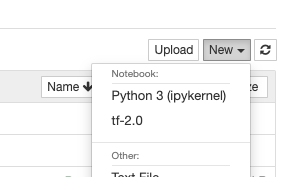

## [WIP - Setting up your Metaflow Flow]
- describe DAG
- best practices for breaking out steps (notebook cells as steps)

-----
**Use Case:** training classifier on CIFAR10 dataset using Pytorch

1. **data-processing**: Download and preprocess CIFAR10 dataset
2. **train**: Train the deep learning model
3. **test-on-test**: Test the model on the test set
4. **test-on-whole**: Test the model performance on the whole dataset

Install Pytorch through Anaconda here: https://pytorch.org/get-started/locally/

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
#download data
input_data_folder = "./data"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=input_data_folder, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=input_data_folder, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# parameter (will put at top of flow)
TRAIN_STEPS = 5

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
#define model

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# Define loss func and optimizer

import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
# train
for epoch in range(TRAIN_STEPS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.190
[1,  4000] loss: 1.875
[1,  6000] loss: 1.708
[1,  8000] loss: 1.597
[1, 10000] loss: 1.526
[1, 12000] loss: 1.463
[2,  2000] loss: 1.380
[2,  4000] loss: 1.374
[2,  6000] loss: 1.327
[2,  8000] loss: 1.332
[2, 10000] loss: 1.272
[2, 12000] loss: 1.276
[3,  2000] loss: 1.200
[3,  4000] loss: 1.203
[3,  6000] loss: 1.195
[3,  8000] loss: 1.185
[3, 10000] loss: 1.177
[3, 12000] loss: 1.168
[4,  2000] loss: 1.087
[4,  4000] loss: 1.112
[4,  6000] loss: 1.094
[4,  8000] loss: 1.113
[4, 10000] loss: 1.096
[4, 12000] loss: 1.098
[5,  2000] loss: 1.009
[5,  4000] loss: 1.025
[5,  6000] loss: 1.018
[5,  8000] loss: 1.046
[5, 10000] loss: 1.038
[5, 12000] loss: 1.043
Finished Training


In [2]:
! pip install matplotlib

     |████████████████████████████████| 7.2 MB 3.6 MB/s eta 0:00:01     |███████████▋                    | 2.6 MB 3.6 MB/s eta 0:00:02
     |████████████████████████████████| 61 kB 506 kB/s  eta 0:00:01


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

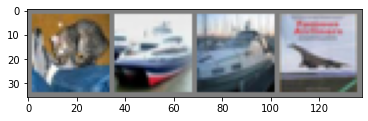

GroundTruth:    cat  ship  ship plane


In [16]:
# test on snippet of test data 
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [12]:
correct = 0
total = 0

In [18]:
#test on whole dataset 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [19]:
#accuracy by class 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 77 %
Accuracy of  bird : 42 %
Accuracy of   cat : 43 %
Accuracy of  deer : 64 %
Accuracy of   dog : 43 %
Accuracy of  frog : 72 %
Accuracy of horse : 72 %
Accuracy of  ship : 76 %
Accuracy of truck : 66 %


`%%writefile` will create the `cifar_classifier.py` file with the following contents into your current local directory:

In [ ]:
# Base Flow for inspiration
from metaflow import FlowSpec, step, conda

class ClassifierFlow(FlowSpec):
    # python 3.9.7
    @conda(libraries={'numpy':'1.20.3', 'matplotlib':'3.4.2'})
    @step
    def start(self):
        # #TO DO
        self.next(self.feature_engineer)
    
    
    @step
    def feature_engineer(self):
        def read_data(path): 
            # # TO DO
            self.next(self.model_train)
            

    @step
    def model_train(self):
        # # TO DO
        self.next(self.model_test)
        
        
    @step
    def model_test(self):        
        # # TO DO
        self.next(self.end)       

    @step
    def end(self):
        pass
        

if __name__ == '__main__':
    ClassifierFlow()

In [ ]:
!python run classifer.py

Using notebooks to interact with Metaflow runs and artifacts. Use runs feature to explore old runs and compare runs 
- find a run and load artifacts for quick visuals
- to check values, or some other debugging

### More Resources:
- Link to article on netflix team using metaflow.client to inject results into a notebook to inspect results 
- [Debugging Metaflow Jobs](https://www.highonscience.com/blog/2021/06/02/metaflow-ml-debugging/)
- https://pythonawesome.com/an-end-to-end-implementation-of-intent-prediction-with-metaflow-and-other-cool-tools/
- [Metaflow Docs - Notebooks](https://docs.metaflow.org/metaflow-on-aws/metaflow-on-aws#notebooks)